In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid
from datetime import datetime, timedelta


In [2]:
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"


animal_name = "Caos"
server_init = r"N:\PonceLab"
save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", f'sim_predict_responce_{animal_name}')
os.makedirs(save_root, exist_ok=True)

# Define the paths to the data
recon_exp_path = os.path.join(data_root, 'recon', f"recon_data_{animal_name}")
proto_exp_path = os.path.join(data_root, "evolution", f"unit_proto_{animal_name}")
scram_exp_path = os.path.join(data_root, "scram", f"unit_scram_{animal_name}")
select_exp_path = os.path.join(data_root, "selectivity", f"select_160_{animal_name}")
# List .mat files in each directory
recon_exp_files = list_mat_files(recon_exp_path)
proto_exp_files = list_mat_files(proto_exp_path)
scram_exp_files = list_mat_files(scram_exp_path)
select_exp_files = list_mat_files(select_exp_path)

day_window = 15
bim_mas_threshold = 1.25

In [3]:
# let load the proto and corosponding mask if it posible plus the size 
# let save the proto and mask and other info in a pd
proto_and_mask_info = pd.DataFrame(columns=['exp_name', 'exp_id', 'proto_img_top_mean', 'proto_img_scram',
                                            'proto_mask_exp', 'proto_mask_lin', 'proto_mask_lin_smoothed',
                                            'proto_size', 'proto_pos', 'chan_id', 'unit_id',
                                            'protoRespMean', 'init_img', 'exp_date'])
c = 0
iamge_size = 256
non_significant_exp = []
for proto_exp_i in range(len(proto_exp_files)):
    # use the extract_info function to extract the information from the filename
    #proto_file = [f for f in proto_exp_files if f.count(f"expId{proto_exp_id+1:03d}")][0]
    proto_file = proto_exp_files[proto_exp_i]
    proto_exp_data = mat73.loadmat(os.path.join(proto_exp_path, proto_file))
    proto_exp_info = extract_info_proto_exp(proto_file)
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])
    chan_id = proto_exp_info['chan']
    unit_id = proto_exp_info['unit']
    proto_exp_id = proto_exp_info['expId']

    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if len(scram_exp_file) == 0:
        continue
    if (proto_exp_data['p_evol'] > .01):
        non_significant_exp.append(proto_exp_id)
        continue
    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']
    protoRespMean = scram_exp_info['protoRespMean']
    exp_date = scram_exp_file.split('_')[0].split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name =animal_name)

    proto_img_top_mean = proto_exp_data['top_mean_img_selected'] # TODO: if you add somthing here you should resize it
    proto_img_scram = scram_exp_info['final_gen_img']
    init_img = proto_exp_data['init_img']
    proto_mask_exp = scram_exp_info['overlapped_mask_exp']
    proto_mask_lin = scram_exp_info['overlapped_mask_lin']
    proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
    # if mask is not the size of image_size then resize it
    if proto_mask_exp.shape[0] != iamge_size:
        proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
    if proto_mask_lin.shape[0] != iamge_size:
        proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
    if proto_mask_lin_smoothed.shape[0] != iamge_size:
        proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
    # if the proto_img is not the size of image_size then resize it
    if proto_img_top_mean.shape[0] != iamge_size:
        proto_img_top_mean = cv2.resize(proto_img_top_mean, (iamge_size, iamge_size))
    if proto_img_scram.shape[0] != iamge_size:
        proto_img_scram = cv2.resize(proto_img_scram, (iamge_size, iamge_size))
    # iloc with c
    proto_and_mask_info.loc[c] = [exp_name_common, proto_exp_id, proto_img_top_mean, proto_img_scram,
                                   proto_mask_exp, proto_mask_lin, proto_mask_lin_smoothed,
                                   proto_size, proto_pos, chan_id, unit_id, protoRespMean, init_img, exp_datetime_obj]
    c += 1
proto_and_mask_info['proto_img_mean_torch'] = proto_and_mask_info['proto_img_top_mean'].apply(uint8_image_to_pytorch)
proto_and_mask_info['proto_img_scram_torch'] = proto_and_mask_info['proto_img_scram'].apply(uint8_image_to_pytorch)
proto_and_mask_info['init_img_torch'] = proto_and_mask_info['init_img'].apply(uint8_image_to_pytorch)
print(f"Number of expected proto images: {len(scram_exp_files)- len(non_significant_exp)}")
print(f"Number of proto images loaded: {len(proto_and_mask_info)}")

Number of expected proto images: 92
Number of proto images loaded: 92


In [4]:
if animal_name == "Caos":
    img_size = 2
if animal_name == "Diablito":
    img_size = 6

pixels_per_deg = 128
# let's get the real pos for the proto image and the mask based on the img_poss and img_size and save them all in a list
# we have all proto_img_torch and proto_mask_tensor so let do it    
real_pos_proto_img_list = [get_real_pos_img_torch(proto_and_mask_info['proto_img_scram_torch'].iloc[i], proto_and_mask_info['proto_pos'].iloc[i], 
                                            proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]
real_pos_init_img_list = [get_real_pos_img_torch(proto_and_mask_info['init_img_torch'].iloc[i], proto_and_mask_info['proto_pos'].iloc[i],
                                            proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]
bin_mask_list = [make_binary_mask_torch(torch.from_numpy(mask), x_std=bim_mas_threshold) for mask in proto_and_mask_info['proto_mask_lin_smoothed'].values]

real_pos_mask_list = [get_real_pos_img_torch(bin_mask_list[i], proto_and_mask_info['proto_pos'].iloc[i],
                                    proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]



proto_chan_id = [proto_and_mask_info['chan_id'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_unit_id = [proto_and_mask_info['unit_id'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_resp_mean = [proto_and_mask_info['protoRespMean'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_exp_date = [proto_and_mask_info['exp_date'].iloc[i] for i in range(len(proto_and_mask_info))]
# let's convert the list to tensor
real_pos_proto_img_tensor = torch.stack(real_pos_proto_img_list)
real_pos_init_img_tensor = torch.stack(real_pos_init_img_list)
real_pos_mask_tensor = torch.stack(real_pos_mask_list)
real_pos_bin_mask_tensor = torch.stack(real_pos_mask_list)
real_pos_proto_img_tensor_masked = apply_mask_to_image_torch(real_pos_proto_img_tensor, real_pos_bin_mask_tensor)
real_pos_init_img_tensor_masked = apply_mask_to_image_torch(real_pos_init_img_tensor, real_pos_bin_mask_tensor)


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


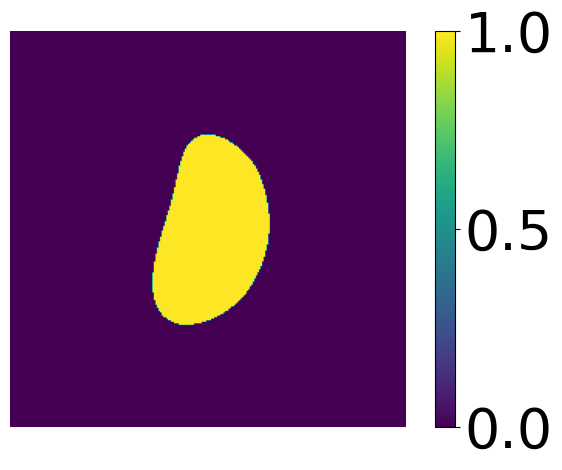

In [5]:
# let print the mask 
proto_scram_id = 12
plt.imshow(proto_and_mask_info['proto_mask_lin'].iloc[proto_scram_id])
plt.axis('off')
plt.colorbar().ax.tick_params(labelsize=40)

plt.tight_layout()
# add color bar
# increas the font size of the color bar
# with dpi 300
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask_not_smmothed.png'), dpi=300)
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask_not_smmothed.pdf'), format='pdf')



plt.imshow(proto_and_mask_info['proto_mask_lin_smoothed'].iloc[proto_scram_id])
plt.axis('off')
plt.tight_layout()
# add color bar
# increas the font size of the color bar
# with dpi 300
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask.png'), dpi=300)
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask.pdf'), format='pdf')


plt.imshow(ToPILImage()(make_binary_mask_torch(torch.from_numpy(proto_and_mask_info['proto_mask_lin_smoothed'].iloc[proto_scram_id]), x_std=bim_mas_threshold)))
plt.axis('off')
plt.tight_layout()
# with dpi 300
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask_cuted.png'), dpi=300)
plt.savefig(os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\scam_results\Caos_chan49_unit1_exp_Caos-03122024-007', 'mask_cuted.pdf'), format='pdf')

In [6]:
# let print all the proto images and masks in the save_path 
# name is this chanXX_unitX_
save_path = os.path.join(save_root, 'proto_images')
os.makedirs(save_path, exist_ok=True)

for i in range(len(proto_and_mask_info)):
    proto_img_plt = ToPILImage()(real_pos_proto_img_list[i])
    proto_maked_img_plt = ToPILImage()(real_pos_proto_img_tensor_masked[i])
    chan_id = proto_chan_id[i]
    unit_id = proto_unit_id[i]
    proto_resp = proto_resp_mean[i]

    proto_img_plt.save(os.path.join(save_path, f"chan{chan_id:02d}_unit{unit_id}_proto_resp{proto_resp:.0f}_{i}.png"))
    proto_maked_img_plt.save(os.path.join(save_path, f"chan{chan_id:02d}_unit{unit_id}_proto_resp{proto_resp:.0f}_masked_{i}.png"))


In [7]:
# let find the exp data and save it in datetime format
select_exp_data_df = pd.DataFrame(columns=['exp_id', 'exp_file_name', 'exp_date', 'all_images_name', 'all_trials_image', 
                                                'bk_resp', 'evoke_resp', 'img_pos', 'img_size', 'chan_ids', 'unit_ids',
                                                'spike_fn','stimuli_fn',
                                                'seletivity_response_mean_zs', 'seletivity_response_mean_real', 'selectivity_response_sem'])
for exp_id in range(len(select_exp_files)):
    select_data = mat73.loadmat(os.path.join(select_exp_path, select_exp_files[exp_id]))
    # let open the data
    # dict_keys(['all_images_name', 'all_trials_image', 'bk_resp', 'evoke_resp', 'img_pos', 'img_size', 'spikeID', 'spike_fn', 'stimuli_fn', 'unitID', 'wvfms'])
    all_images_name = select_data['all_images_name']
    all_images_name = np.array([x[0] for x in all_images_name])
    all_trials_image = select_data['all_trials_image']
    all_trials_image = np.array([x[0] for x in all_trials_image])
    bk_resp = select_data['bk_resp']
    evoke_resp = select_data['evoke_resp']
    img_pos = select_data['img_pos']
    img_size = select_data['img_size']
    chan_ids = select_data['spikeID']
    spike_fn = select_data['spike_fn']
    stimuli_fn = select_data['stimuli_fn']
    unit_ids = select_data['unitID']
    exp_date = spike_fn.split('_')[0].split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name)

    evoke_resp_ZS = stats.zscore(evoke_resp, axis=1, nan_policy='omit')

    seletivity_response_mean_zs = np.zeros((len(all_images_name), len(chan_ids)))
    seletivity_response_mean_real = np.zeros((len(all_images_name), len(chan_ids)))
    selectivity_response_sem = np.zeros((len(all_images_name), len(chan_ids)))
    for ii, img in enumerate(all_images_name):
        # let find the index of the image in the all_trials_image
        img_idx = np.where(np.array(all_trials_image) == img)[0]
        # let get the mean and sem of the responses
        seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
        seletivity_response_mean_real[ii, :] = np.nanmean(evoke_resp[:, img_idx], axis=1)
        selectivity_response_sem[ii, :] = np.nanstd(evoke_resp[:, img_idx], axis=1) / np.sqrt(np.shape(evoke_resp[:, img_idx])[1])

    # let save the data in the pd
    select_exp_data_df.loc[len(select_exp_data_df)] = [exp_id, select_exp_files[exp_id], exp_datetime_obj, all_images_name, all_trials_image,
                                                        bk_resp, evoke_resp, img_pos, img_size, chan_ids, unit_ids, spike_fn, stimuli_fn,
                                                        seletivity_response_mean_zs, seletivity_response_mean_real, selectivity_response_sem]


C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880\3086468014.py:34: RuntimeWarning: Mean of empty slice
  seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880\3086468014.py:34: RuntimeWarning: Mean of empty slice
  seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880\3086468014.py:34: RuntimeWarning: Mean of empty slice
  seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880\3086468014.py:34: RuntimeWarning: Mean of empty slice
  seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880\3086468014.py:34: RuntimeWarning: Mean of empty slice
  seletivity_response_mean_zs[ii, :] = np.nanmean(evoke_resp_ZS[:, img_idx], axis=1)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_9880

In [8]:
import warnings
warnings.filterwarnings("ignore")

from core.utils.image_similarity import TorchImageDistance
def plot_madoul(x_clean, y_clean, ax):
    ax.scatter(x_clean, y_clean)
    # Line of best fit
    m1, b1 = np.polyfit(x_clean, y_clean, 1)
    ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
    # Calculate the correlation coefficient
    corr_coeff1 = np.corrcoef(x_clean, y_clean)[0, 1]
    ax.text(.7, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

In [9]:
time_window = timedelta(days=day_window)
pixels_per_deg = 128
save_path = os.path.join(save_root, 'most_least_active_images_vs_proto')
os.makedirs(save_path, exist_ok=True)
img_dist_obj_masked = TorchImageDistance()
img_dist_obj_raw = TorchImageDistance()

# let have df to save the distance and responce and other info in an dataframe

respnce_vs_distance_df = pd.DataFrame(columns=['proto_exp_id', 'chan_id', 'unit_id', 'select_exp_id', 'proto_exp_date', 'proto_resp_mean',
                                               'img_size', 'unit_resp', 'img_proto_dist_masked', 'img_proto_dist_raw', 
                                                'resp_vs_distance_corr_masked', 'resp_vs_distance_corr_raw',
                                                'resp_vs_distance_corr_r2_masked', 'resp_vs_distance_corr_p_masked',
                                                'resp_vs_distance_corr_r2_raw', 'resp_vs_distance_corr_p_raw'])
for proto_scram_id in range(len(proto_and_mask_info)):

    proto_exp_date = proto_and_mask_info['exp_date'].iloc[proto_scram_id]
    proto_chan_id = proto_and_mask_info['chan_id'].iloc[proto_scram_id]
    proto_unit_id = proto_and_mask_info['unit_id'].iloc[proto_scram_id]
    proto_resp_mean = proto_and_mask_info['protoRespMean'].iloc[proto_scram_id]
    # find colsest selectivity exp date
    proto_select_exp_diff = (select_exp_data_df['exp_date'].apply(lambda x: abs(x - proto_exp_date)))
    select_exp_date_argsort = np.argsort(proto_select_exp_diff)
    select_exp_id = -1
    c= 0
    while proto_select_exp_diff[select_exp_date_argsort[c]]<time_window :
        curent_select_exp_id = select_exp_date_argsort[c]
        cell_locator = np.isin(select_exp_data_df['chan_ids'][curent_select_exp_id], proto_chan_id) & np.isin(select_exp_data_df['unit_ids'][curent_select_exp_id], proto_unit_id)
        if np.sum(cell_locator) == 1:
            select_exp_id = curent_select_exp_id
            #cc = select_exp_data_df['chan_ids'][curent_select_exp_id][cell_locator]
            #ii = select_exp_data_df['unit_ids'][curent_select_exp_id][cell_locator]
            break
        c = c+1
    
    # let continue if no selectivity exp found
    if select_exp_id == -1:
        print(f'No selectivity exp found for proto exp {proto_scram_id} -> chan {proto_chan_id} -> unit {proto_unit_id}')
        continue

    # let load the slectivity image
    stimuli_fn = select_exp_data_df['stimuli_fn'].iloc[select_exp_id]
    all_images_name = select_exp_data_df['all_images_name'].iloc[select_exp_id]
    select_160_images = pd.DataFrame(columns=['img_name', 'img_torch'])
    for img_i in range(len(all_images_name)):
        img_name = all_images_name[img_i]
        img_path_folder = os.path.join(server_init, prune_path(stimuli_fn))
        # get all files in the folder that is similar to the image name
        full_img_name = [f for f in os.listdir(img_path_folder) if f.count(img_name)][0]
        img = Image.open(os.path.join(img_path_folder, full_img_name)).convert('RGB')

        select_160_images.loc[img_i] = [img_name, load_preprocess(img)]

    # let make it tensor with same orther of the all_images_name    
    select_160_images_tensor = list()
    for img_name in all_images_name:
        select_160_images_tensor.append(select_160_images[select_160_images['img_name'] == img_name]['img_torch'].values[0])
    select_160_images_tensor = torch.stack(select_160_images_tensor)

    img_size = select_exp_data_df['img_size'].iloc[select_exp_id]
    # let's get the real pos for the proto image and the mask based on the img_poss and img_size and save them 
    real_pos_proto_img = get_real_pos_img_torch(proto_and_mask_info['proto_img_scram_torch'].iloc[proto_scram_id], proto_and_mask_info['proto_pos'].iloc[proto_scram_id], 
                                                proto_and_mask_info['proto_size'].iloc[proto_scram_id], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
    real_pos_init_img_list = get_real_pos_img_torch(proto_and_mask_info['init_img_torch'].iloc[proto_scram_id], proto_and_mask_info['proto_pos'].iloc[proto_scram_id],
                                                proto_and_mask_info['proto_size'].iloc[proto_scram_id], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
    bin_mask = make_binary_mask_torch(torch.from_numpy(proto_and_mask_info['proto_mask_lin_smoothed'].iloc[proto_scram_id]), x_std=bim_mas_threshold)
    real_pos_bin_mask = get_real_pos_img_torch(bin_mask, proto_and_mask_info['proto_pos'].iloc[proto_scram_id],
                                                proto_and_mask_info['proto_size'].iloc[proto_scram_id], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
    

    real_pos_proto_img_masked = apply_mask_to_image_torch(real_pos_proto_img, real_pos_bin_mask).squeeze(0)
    real_pos_init_img_masked = apply_mask_to_image_torch(real_pos_init_img_list, real_pos_bin_mask).squeeze(0)
    # let's get the mask center
    mask_center = find_mask_center(real_pos_bin_mask)
    mask_center_deg = mask_center[2]
    real_pos_proto_img_masked_centered = get_real_pos_img_torch(real_pos_proto_img_masked, -mask_center_deg, img_size,
                                                                screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
    real_pos_init_img_masked_centered = get_real_pos_img_torch(real_pos_init_img_masked, -mask_center_deg, img_size,
                                                                screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
    img_size_pixels = int(img_size * pixels_per_deg)
    select_160_images_tensor = F.resize(select_160_images_tensor, [img_size_pixels, img_size_pixels])

    select_160_images_tensor_masked = apply_mask_to_image_torch(select_160_images_tensor, real_pos_bin_mask.repeat(len(select_160_images_tensor), 1, 1))
    target_img_repeated_masked_centered = torch.stack([get_real_pos_img_torch(select_160_images_tensor_masked[i], -mask_center_deg, img_size,
                                                                        screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(select_160_images_tensor_masked))])

    # let get the response focus cell for the all selectivity images
    seletivity_response_mean_real = select_exp_data_df['seletivity_response_mean_real'].iloc[select_exp_id]
    unit_resp = seletivity_response_mean_real[:, cell_locator].squeeze()

    # let resort the select_160_images_tensor based on the unit_resp (descending)
    sort_idx = np.argsort(unit_resp, axis=0)
    unit_resp_sort = unit_resp[sort_idx]
    select_160_images_tensor_sorted_masked = select_160_images_tensor_masked[sort_idx]
    select_160_images_tensor_sorted = select_160_images_tensor[sort_idx]

    # let mask the select_160_images and print most active and least active
    real_pos_proto_img_masked_with_text = add_text_to_image(real_pos_proto_img_masked, f"{proto_resp_mean:.2f}", (10, 10))
    all_images = torch.cat([real_pos_proto_img_masked_with_text.unsqueeze(0),\
                        add_text_to_image(select_160_images_tensor_sorted_masked[-8:], [f"{t:.2f}" for t in unit_resp_sort[-8:]], (10, 10)),\
                        real_pos_proto_img_masked_with_text.unsqueeze(0), add_text_to_image(select_160_images_tensor_sorted_masked[:8], [f"{t:.2f}" for t in unit_resp_sort[:8]], (10, 10))])
    # let make a grid of them
    grid = make_grid(all_images, nrow=9, padding=10, pad_value=1)
    plt.figure(figsize=(40, 40))
    plt.imshow(ToPILImage()(grid))
    plt.axis('off')
    # in title we want this in order: proto exp date - unit id - channel id - selectivity exp date
    plt.title(f"{proto_exp_date.strftime('%Y-%m-%d')} - unit {proto_unit_id} - channel {proto_chan_id} - {select_exp_data_df['exp_date'].iloc[select_exp_id].strftime('%Y-%m-%d')}", fontsize=40)
    # let save the ima
    plt.savefig(os.path.join(save_path, f"unit_{proto_unit_id}_channel_{proto_chan_id}_masked.png"), bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f"unit_{proto_unit_id}_channel_{proto_chan_id}_masked.pdf"), bbox_inches='tight', format='pdf')
    plt.close()

    # let mask the select_160_images and print most active and least active
    real_pos_proto_img_with_text = add_text_to_image(real_pos_proto_img, f"{proto_resp_mean:.2f}", (10, 10))
    all_images = torch.cat([real_pos_proto_img_with_text.unsqueeze(0),\
                        add_text_to_image(select_160_images_tensor_sorted[-8:], [f"{t:.2f}" for t in unit_resp_sort[-8:]], (10, 10)),\
                        real_pos_proto_img_with_text.unsqueeze(0), add_text_to_image(select_160_images_tensor_sorted[:8], [f"{t:.2f}" for t in unit_resp_sort[:8]], (10, 10))])
    # let make a grid of them
    grid = make_grid(all_images, nrow=9, padding=10, pad_value=1)
    plt.figure(figsize=(40, 40))
    plt.imshow(ToPILImage()(grid))
    plt.axis('off')
    # in title we want this in order: proto exp date - unit id - channel id - selectivity exp date
    plt.title(f"{proto_exp_date.strftime('%Y-%m-%d')} - unit {proto_unit_id} - channel {proto_chan_id} - {select_exp_data_df['exp_date'].iloc[select_exp_id].strftime('%Y-%m-%d')}", fontsize=40)
    # let save the ima
    plt.savefig(os.path.join(save_path, f"unit_{proto_unit_id}_channel_{proto_chan_id}_all.png"), bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f"unit_{proto_unit_id}_channel_{proto_chan_id}_all.pdf"), bbox_inches='tight', format='pdf')
    plt.close()

    # let find the similarity
    real_pos_proto_img_masked_centered_tensor = real_pos_proto_img_masked_centered.repeat(len(target_img_repeated_masked_centered), 1, 1, 1)
    real_pos_proto_img_tensor = real_pos_proto_img.repeat(len(target_img_repeated_masked_centered), 1, 1, 1)

    img_dist_obj_masked.set_first_image_batch(real_pos_proto_img_masked_centered_tensor)
    img_dist_obj_masked.set_second_image_batch(target_img_repeated_masked_centered)
    img_proto_dist_masked,_ = img_dist_obj_masked.get_CCN_distance(units_slice='center')
    # let save the result

    img_dist_obj_raw.set_first_image_batch(real_pos_proto_img_tensor)
    img_dist_obj_raw.set_second_image_batch(select_160_images_tensor)
    img_proto_dist_raw,_ = img_dist_obj_raw.get_CCN_distance(units_slice='all')

    resp_vs_distance_corr_masked = np.corrcoef(unit_resp, img_proto_dist_masked)[0, 1]
    resp_vs_distance_corr_raw = np.corrcoef(unit_resp, img_proto_dist_raw)[0, 1]

    resp_vs_distance_corr_r2, resp_vs_distance_corr_p = stats.pearsonr(unit_resp, img_proto_dist_masked)
    resp_vs_distance_corr_r2_raw, resp_vs_distance_corr_p_raw = stats.pearsonr(unit_resp, img_proto_dist_raw)

    '''fig, ax = plt.subplots(1,2, figsize=(8, 4))
    plot_madoul(unit_resp, img_proto_dist_masked, ax[0])
    ax[0].set_xlabel('Response')
    ax[0].set_ylabel('Distance')
    # add line in resp for proto resp
    ax[0].axvline(proto_resp_mean, color='red', linestyle='--')
    ax[0].set_title('Masked')


    plot_madoul(unit_resp, img_proto_dist_raw, ax[1])
    ax[1].set_xlabel('Response')
    ax[1].set_ylabel('Distance')
    # add line in resp for proto resp
    ax[1].axvline(proto_resp_mean, color='red', linestyle='--')
    ax[1].set_title('all')
    plt.tight_layout()'''
    # let save the result
    respnce_vs_distance_df.loc[len(respnce_vs_distance_df)] = [proto_scram_id, proto_chan_id, proto_unit_id, select_exp_id, proto_exp_date, proto_resp_mean,
                                                                img_size, unit_resp, img_proto_dist_masked, img_proto_dist_raw,
                                                                resp_vs_distance_corr_masked, resp_vs_distance_corr_raw, 
                                                                resp_vs_distance_corr_r2, resp_vs_distance_corr_p, resp_vs_distance_corr_r2_raw, resp_vs_distance_corr_p_raw]

img_dist_obj_masked.memory_cleanup()   
img_dist_obj_raw.memory_cleanup() 


The CNN scorers are set
The CNN scorers are set
No selectivity exp found for proto exp 1 -> chan 90 -> unit 2
No selectivity exp found for proto exp 2 -> chan 49 -> unit 2
No selectivity exp found for proto exp 58 -> chan 79 -> unit 2
No selectivity exp found for proto exp 62 -> chan 71 -> unit 2
No selectivity exp found for proto exp 63 -> chan 72 -> unit 2
No selectivity exp found for proto exp 64 -> chan 79 -> unit 1
No selectivity exp found for proto exp 68 -> chan 49 -> unit 2
No selectivity exp found for proto exp 78 -> chan 80 -> unit 2
No selectivity exp found for proto exp 79 -> chan 40 -> unit 1
No selectivity exp found for proto exp 80 -> chan 65 -> unit 2
No selectivity exp found for proto exp 81 -> chan 51 -> unit 2
No selectivity exp found for proto exp 82 -> chan 96 -> unit 1
No selectivity exp found for proto exp 83 -> chan 5 -> unit 2
No selectivity exp found for proto exp 84 -> chan 78 -> unit 2
No selectivity exp found for proto exp 85 -> chan 68 -> unit 2
No selecti

In [10]:
img_dist_obj_masked.memory_cleanup()   
img_dist_obj_raw.memory_cleanup() 

Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [11]:
# let save the df 
respnce_vs_distance_df.to_hdf(os.path.join(save_root, f'respnce_vs_distance_df_{animal_name}.h5'), key=f'respnce_vs_distance_df_{animal_name}', mode='w')

Error in unit 2 channel 28


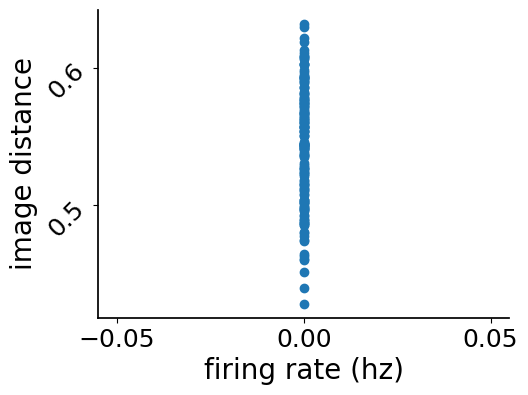

In [12]:
# print single neurons example
save_path = os.path.join(save_root, 'individual_examples')
os.makedirs(save_path, exist_ok=True)

# let ahve function that get x and y arrays which have corespondnding values and then clean the nan values and return the cleaned x and y
def clean_nan(x, y):
    # let get rid of nan values
    nan_idx = np.isnan(x) | np.isnan(y)
    x_clean = x[~nan_idx]
    y_clean = y[~nan_idx]
    return x_clean, y_clean 

for i in range(len(respnce_vs_distance_df['unit_resp'])):
    try:
        fig, ax = plt.subplots(1,1, figsize=(5.3, 4))
        x_clean, y_clean = clean_nan(respnce_vs_distance_df['unit_resp'].iloc[i], respnce_vs_distance_df['img_proto_dist_masked'].iloc[i])
        ax.scatter(x_clean, y_clean)
        font_size = 20
        ax.set_xlabel('firing rate (hz)', fontsize=font_size)
        ax.set_ylabel('image distance', fontsize=font_size)
        # set xticks and yticks font size
        ax.tick_params(axis='both', which='major', labelsize=18)
        # rotate the just y ticks
        plt.yticks(rotation=45)
        # just keep 3 vales for both x and y ticks
        ax.locator_params(nbins=4)
        # change both axix line whidth to 1.25
        ax.spines['bottom'].set_linewidth(1.25)
        ax.spines['left'].set_linewidth(1.25)
        # add a linear regration
        m1, b1 = np.polyfit(x_clean, y_clean, 1)
        ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
        # get p value
        r2, p = stats.pearsonr(x_clean, y_clean)
        ax.text(.7, 0.95, f'Corr Coeff: {r2:.2f}', transform=ax.transAxes, fontsize=15, verticalalignment='top')
        # if p vlue < 10^-5 add  p vlue < 10^-5 otherwise add the value
        if p < 10**-5:
            ax.text(.7, 0.85, 'p value < $10^{-5}$', transform=ax.transAxes, fontsize=15, verticalalignment='top')
        else:
            ax.text(.7, 0.85, f'p value: {p:.4f}', transform=ax.transAxes, fontsize=15, verticalalignment='top')
        #ax.axvline(respnce_vs_distance_df['proto_resp_mean'].iloc[i], color='red', linestyle='--')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f"unit_{respnce_vs_distance_df['unit_id'].iloc[i]}_channel_{respnce_vs_distance_df['chan_id'].iloc[i]}.png"), dpi=300)
        plt.savefig(os.path.join(save_path, f"unit_{respnce_vs_distance_df['unit_id'].iloc[i]}_channel_{respnce_vs_distance_df['chan_id'].iloc[i]}.pdf"), format='pdf')
        plt.close()




        # let add the img_proto_dist_raw t it with smaller dots
        fig, ax = plt.subplots(1,1, figsize=(5, 4))
        x_clean_raw, y_clean_raw = clean_nan(respnce_vs_distance_df['unit_resp'].iloc[i], respnce_vs_distance_df['img_proto_dist_raw'].iloc[i])
        x_clean_masked, y_clean_masked = clean_nan(respnce_vs_distance_df['unit_resp'].iloc[i], respnce_vs_distance_df['img_proto_dist_masked'].iloc[i])
        ax.scatter(x_clean_masked, y_clean_masked, color='blue', alpha=0.5)
        ax.scatter(x_clean_raw, y_clean_raw, color='black', alpha=0.5)
        font_size = 20
        ax.set_xlabel('firing rate (hz)', fontsize=font_size)
        ax.set_ylabel('image distance', fontsize=font_size)
        # set xticks and yticks font size
        ax.tick_params(axis='both', which='major', labelsize=18)
        # rotate the just y ticks
        plt.yticks(rotation=45)
        # just keep 3 vales for both x and y ticks
        ax.locator_params(nbins=4)
        # change both axix line whidth to 1.25
        ax.spines['bottom'].set_linewidth(1.25)
        ax.spines['left'].set_linewidth(1.25)
        # add a linear regration
        m1, b1 = np.polyfit(x_clean_masked, y_clean_masked, 1)
        ax.plot(x_clean_masked, m1*x_clean_masked + b1, color='blue')  # Add line of best fit

        m1, b1 = np.polyfit(x_clean_raw, y_clean_raw, 1)
        ax.plot(x_clean_raw, m1*x_clean_raw + b1, color='black')  # Add line of best fit
        # get p value


        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f"unit_{respnce_vs_distance_df['unit_id'].iloc[i]}_channel_{respnce_vs_distance_df['chan_id'].iloc[i]}_with_all.png"), dpi=300)
        plt.savefig(os.path.join(save_path, f"unit_{respnce_vs_distance_df['unit_id'].iloc[i]}_channel_{respnce_vs_distance_df['chan_id'].iloc[i]}_with_all.pdf"), format='pdf')
        plt.close()
    except:
        print(f'Error in unit {respnce_vs_distance_df["unit_id"].iloc[i]} channel {respnce_vs_distance_df["chan_id"].iloc[i]}')
        continue



p value for the difference between masked and raw - wilcoxon signed rank test: 0.0013
percentage of significant masked:, 69.01
percentage of significant raw:, 50.70
numner of neurons in the df: 71
number of neurons single neurons: 40


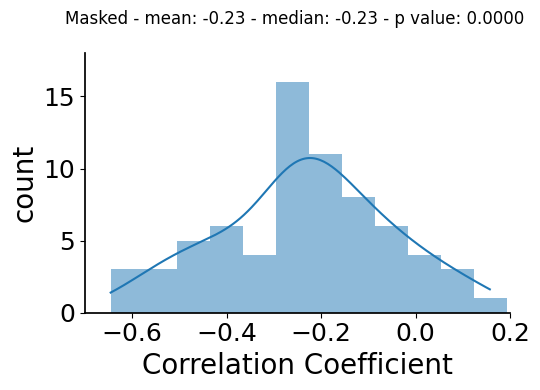

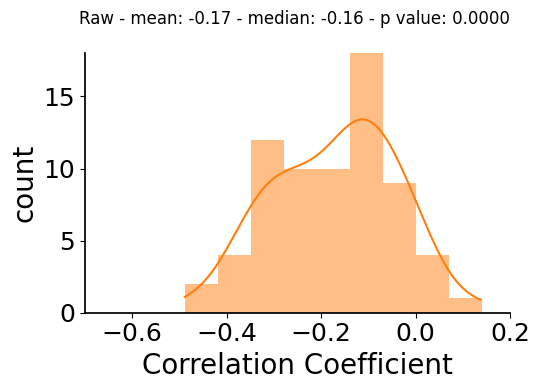

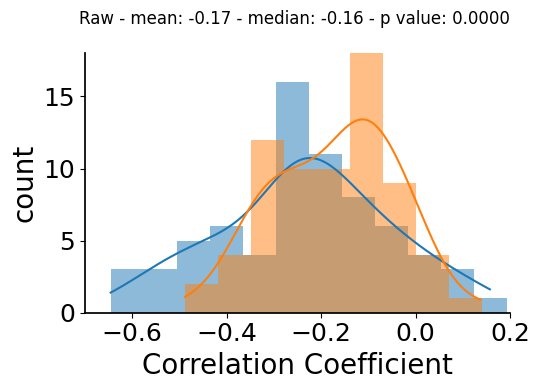

In [13]:
# let plot the distribution of the correlation coefficient for the masked 
save_path = os.path.join(save_root, 'corr_dist')
os.makedirs(save_path, exist_ok=True)

fig, ax = plt.subplots(1,1, figsize=(5.5, 4))
# let get two mice sns colors
colors = sns.color_palette("tab10", 2)
resp_vs_distance_corr_masked = respnce_vs_distance_df['resp_vs_distance_corr_masked'][(~np.isnan(respnce_vs_distance_df['resp_vs_distance_corr_raw'])) & (~np.isnan(respnce_vs_distance_df['resp_vs_distance_corr_masked']))]
sns.histplot(resp_vs_distance_corr_masked, kde=True, label='masked', alpha=0.5, binwidth=0.07, color=colors[0], linewidth=0)

# whether this distribution is sinifcantly less than 0
p_val = stats.wilcoxon(resp_vs_distance_corr_masked)[1]
# let add mean and median to the plot as text to the title plot p vlue and if the p vlue < 10^-5 add  p vlue < 10^-5 otherwise add the value
ax.set_title(f"Masked - mean: {np.mean(resp_vs_distance_corr_masked):.2f} - median: {np.median(resp_vs_distance_corr_masked):.2f} - p value: {p_val:.4f} \n")
ax.tick_params(axis='both', which='major', labelsize=18)
# let add the axis labels 
font_size = 20
ax.set_xlabel('Correlation Coefficient', fontsize=font_size)
ax.set_ylabel('count', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
ax.set_xlim(-.7, .2)
ax.set_ylim(0, 18)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_masked.png"), dpi=300)
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_masked.pdf"), format='pdf')

# let plot the distribution of the correlation coefficient for the raw
fig, ax = plt.subplots(1,1, figsize=(5.5, 4))
resp_vs_distance_corr_raw = respnce_vs_distance_df['resp_vs_distance_corr_raw'][(~np.isnan(respnce_vs_distance_df['resp_vs_distance_corr_raw'])) & (~np.isnan(respnce_vs_distance_df['resp_vs_distance_corr_masked']))] 
sns.histplot(resp_vs_distance_corr_raw, kde=True, label='raw', alpha=0.5, binwidth=0.07, color=colors[1], linewidth=0)
# let plot that masked in the filied over the x axis

# whether this distribution is sinifcantly less than 0
p_val = stats.wilcoxon(resp_vs_distance_corr_raw)[1]
# let add mean and median to the plot as text to the title plot p vlue and if the p vlue < 10^-5 add  p vlue < 10^-5 otherwise add the value
ax.set_title(f"Raw - mean: {np.mean(resp_vs_distance_corr_raw):.2f} - median: {np.median(resp_vs_distance_corr_raw):.2f} - p value: {p_val:.4f} \n")
ax.tick_params(axis='both', which='major', labelsize=18)
# let add the axis labels
font_size = 20
ax.set_xlabel('Correlation Coefficient', fontsize=font_size)
ax.set_ylabel('count', fontsize=font_size)

# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
ax.set_xlim(-.7, .2)
ax.set_ylim(0, 18)
# let 180 degre rotation for y ticks'
#plt.yticks(rotation=180)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_raw.png"), dpi=300)
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_raw.pdf"), format='pdf')

# let plot the distribution of the correlation coefficient for the raw
fig, ax = plt.subplots(1,1, figsize=(5.5, 4))
sns.histplot(resp_vs_distance_corr_masked, kde=True, label='masked', alpha=0.5, binwidth=0.07, color=colors[0], linewidth=0)
sns.histplot(resp_vs_distance_corr_raw, kde=True, label='raw', alpha=0.5, binwidth=0.07, color=colors[1], linewidth=0)
# let plot that masked in the filied over the x axis

# whether this distribution is sinifcantly less than 0
p_val = stats.wilcoxon(resp_vs_distance_corr_raw)[1]
# let add mean and median to the plot as text to the title plot p vlue and if the p vlue < 10^-5 add  p vlue < 10^-5 otherwise add the value
ax.set_title(f"Raw - mean: {np.mean(resp_vs_distance_corr_raw):.2f} - median: {np.median(resp_vs_distance_corr_raw):.2f} - p value: {p_val:.4f} \n")
ax.tick_params(axis='both', which='major', labelsize=18)
# let add the axis labels
font_size = 20
ax.set_xlabel('Correlation Coefficient', fontsize=font_size)
ax.set_ylabel('count', fontsize=font_size)

# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
ax.set_xlim(-.7, .2)
ax.set_ylim(0, 18)
# let 180 degre rotation for y ticks'
#plt.yticks(rotation=180)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_bot.png"), dpi=300)
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_bot.pdf"), format='pdf')


# let see whether the correlation coefficient is significantly different between the masked and raw
# let do wilcoxon signed rank test
p_vall_diff = stats.wilcoxon(resp_vs_distance_corr_masked, resp_vs_distance_corr_raw)[1]
print(f"p value for the difference between masked and raw - wilcoxon signed rank test: {p_vall_diff:.4f}")
# let see the percentage of sifnificant for each 
print(f"percentage of significant masked:, {np.sum(respnce_vs_distance_df['resp_vs_distance_corr_p_masked']<0.05)/len(respnce_vs_distance_df)*100:.2f}")
print(f"percentage of significant raw:, {np.sum(respnce_vs_distance_df['resp_vs_distance_corr_p_raw']<0.05)/len(respnce_vs_distance_df)*100:.2f}")

# let see the number of all sites which is the len of the df
print('numner of neurons in the df:', len(respnce_vs_distance_df))
print('number of neurons single neurons:', np.sum(respnce_vs_distance_df['unit_id']>1))

## Let get the distribuation without bars




In [14]:
# let have permutation test for the correlation and get the p value and then apply the correction later
def perm_test_corr(x, y, n_perm=500):
    corr_obs = np.corrcoef(x, y)[0, 1]
    n = len(x)
    perm_corr = np.zeros(n_perm)
    for i in range(n_perm):
        perm_x = np.random.permutation(x)
        perm_corr[i] = np.corrcoef(perm_x, y)[0, 1]
    p_value = np.sum(np.abs(perm_corr) > np.abs(corr_obs)) / n_perm
    return p_value

In [15]:
# let flag the cells that have more tghat 25% respomsed to nat images than proto_resp_mean
respnce_vs_distance_df['more_than_25'] = np.array( [(np.sum(respnce_vs_distance_df['unit_resp'].iloc[i] > respnce_vs_distance_df['proto_resp_mean'].iloc[i]) / len(respnce_vs_distance_df['unit_resp'].iloc[i])) > 0.25
                                                     for i in range(len(respnce_vs_distance_df))])

# let nrmaize the resp with the proto resp mean and z score the distance for each proto exp
respnce_vs_distance_df['unit_resp_norm'] = respnce_vs_distance_df.apply(lambda x: x['unit_resp'] / x['proto_resp_mean'], axis=1)
respnce_vs_distance_df['img_proto_dist_masked_z'] = respnce_vs_distance_df.apply(lambda x: (x['img_proto_dist_masked'] - np.mean(x['img_proto_dist_masked'])) / np.std(x['img_proto_dist_masked']), axis=1)
respnce_vs_distance_df['img_proto_dist_raw_z'] = respnce_vs_distance_df.apply(lambda x: (x['img_proto_dist_raw'] - np.mean(x['img_proto_dist_raw'])) / np.std(x['img_proto_dist_raw']), axis=1)
respnce_vs_distance_df['prem_test_corr_masked'] = respnce_vs_distance_df.apply(lambda x: perm_test_corr(x['unit_resp_norm'], x['img_proto_dist_masked_z']), axis=1)
respnce_vs_distance_df['prem_test_corr_raw'] = respnce_vs_distance_df.apply(lambda x: perm_test_corr(x['unit_resp_norm'], x['img_proto_dist_raw_z']), axis=1)

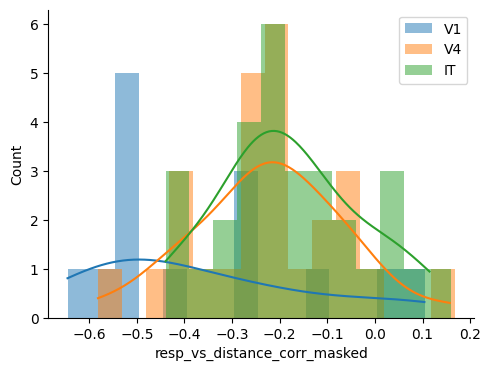

In [16]:
# the cell distribuation is this
# V1: 1 : 32
# V4: 33 : 64
# IT: 65 : 96

# let look the distribution of the correlation coefficient for each area
if animal_name == 'Caos':
    v1_border = 32
    v4_border = 64
    it_border = 96
elif animal_name == 'Diablito':
    v1_border = 16
    v4_border = 32
    it_border = 64
# get some sns color for three areas
colors = sns.color_palette("tab10", 3)

fig, ax = plt.subplots(1,1, figsize=(5.5, 4))
sns.histplot(respnce_vs_distance_df['resp_vs_distance_corr_masked'][respnce_vs_distance_df['chan_id'] <= v1_border], kde=True, label='V1', alpha=0.5, binwidth=0.05, color=colors[0], linewidth=0)
sns.histplot(respnce_vs_distance_df['resp_vs_distance_corr_masked'][(respnce_vs_distance_df['chan_id'] > v1_border) & (respnce_vs_distance_df['chan_id'] <= v4_border)], kde=True, label='V4', alpha=0.5, binwidth=0.05, color=colors[1], linewidth=0)
sns.histplot(respnce_vs_distance_df['resp_vs_distance_corr_masked'][respnce_vs_distance_df['chan_id'] > v4_border], kde=True, label='IT', alpha=0.5, binwidth=0.05, color=colors[2], linewidth=0)
plt.legend()
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_mask_across_areas.pdf"), dpi=300)
plt.savefig(os.path.join(save_path, f"resp_vs_distance_corr_mask_across_areas.png"), format='png')


(0.0, 1.5)

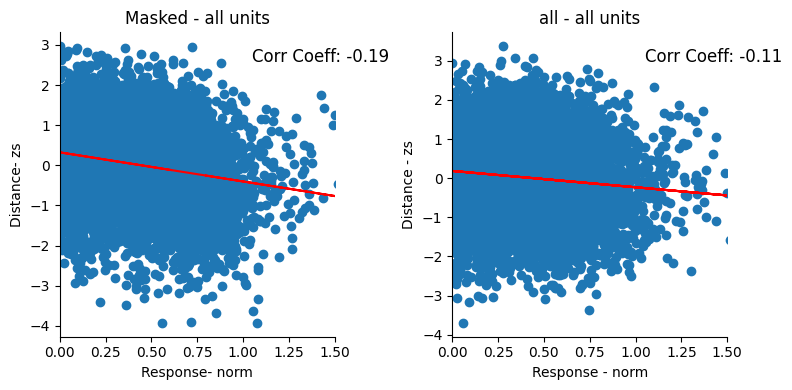

In [17]:
# let concat the the norm resp and z score distance for the all units
row_filter = ~respnce_vs_distance_df['more_than_25'] & (respnce_vs_distance_df['resp_vs_distance_corr_p_masked']<0.05)

unit_resp_norm_all = np.concatenate(respnce_vs_distance_df['unit_resp_norm'][row_filter].values)
img_proto_dist_masked_z_all = np.concatenate(respnce_vs_distance_df['img_proto_dist_masked_z'][row_filter].values)
img_proto_dist_raw_z_all = np.concatenate(respnce_vs_distance_df['img_proto_dist_raw_z'][row_filter].values)

# let plot the correlation between the resp and distance for all units
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_madoul(unit_resp_norm_all, img_proto_dist_masked_z_all, ax[0])
ax[0].set_xlabel('Response- norm')
ax[0].set_ylabel('Distance- zs')
ax[0].set_title('Masked - all units')
# set a limit 
ax[0].set_xlim([0, 1.5])

plot_madoul(unit_resp_norm_all, img_proto_dist_raw_z_all, ax[1])
ax[1].set_xlabel('Response - norm')
ax[1].set_ylabel('Distance - zs')
ax[1].set_title('all - all units')
plt.tight_layout()
ax[1].set_xlim([0, 1.5])
